In [21]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
from multielo import MultiElo
import statistics
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
elo = MultiElo()

In [30]:
df = pd.read_csv('../data/contest_results_multi_elo.csv', parse_dates=['contest_date'], index_col=0)
df.loc[df["multielo_rank"] > 15, "multielo_rank"] = 16

In [31]:
df = df.sort_values(
    by=[
        "contest_date",
        "organization",
        "contest_name",
        "division",
        "class",
        "placing"
    ],
    ascending=True,
)

In [9]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,multielo_rating,professional_only,multielo_rank
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1,1555.253385,True,2.0
17037,ifbb,ifbb flex pro,2012-02-18,fitness,open,oksana grishina,2,1549.920051,True,3.0
17036,ifbb,ifbb flex pro,2012-02-18,fitness,open,myriam capes,3,1521.856488,False,8.0
17035,ifbb,ifbb flex pro,2012-02-18,fitness,open,tanji johnson,4,1539.253385,True,4.0
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5,1533.920051,True,5.0


# Evaluating Ranking Metrics

In [16]:
df_groupby = df.groupby(by=["contest_date", "organization", "division", "class"])

In [ ]:
rows_list = []
for names, df_dt in df_groupby:
    kt_corr = []
    prec_5_scores = []
    multielo_prob = []
    multielo_prob_random = []
    for ctst in df_dt["contest_name"].unique():
        temp_df = df_dt[df_dt["contest_name"] == ctst]
        temp_df = temp_df.dropna()
        if len(temp_df) < 2:
            continue
        y_true = temp_df["placing"]
        y_predict = temp_df["multielo_rank"]
        y_multielo_rating = list(temp_df["multielo_rating"])
        multielo_prob.append(statistics.mean(list(np.diag(elo.simulate_win_probabilities(y_multielo_rating)))))
        random.shuffle(y_multielo_rating)
        multielo_prob_random.append(statistics.mean(list(np.diag(elo.simulate_win_probabilities(y_multielo_rating)))))
        kt_corr.append(kendalltau(y_true, y_predict).statistic)
        y_predict = list(y_predict)
        random.shuffle(y_predict)
        if len(temp_df) > 5:
            top_5_placing = temp_df.sort_values(by=['placing'], ascending=True).head(5)
            top_5_elo = temp_df.sort_values(by=['multielo_rank'], ascending=True).head(5)
            prec_5_scores.append(0.2 * len(pd.merge(top_5_placing, top_5_elo, how='inner', on=['competitor_name'])))
    if kt_corr:
        if not prec_5_scores:
            prec_5_score = None
        else:
            prec_5_score = sum(prec_5_scores) / len(prec_5_scores)
        rows_list.append(
            {   "date": names[0],
                "organization": names[1],
                "division": names[2],
                "class": names[3],
                "kt_corr": sum(kt_corr) / len(kt_corr),
                "prec_5_score": prec_5_score,
                "multielo_prob": sum(multielo_prob)/len(multielo_prob),
                "multielo_prob_random": sum(multielo_prob_random)/len(multielo_prob_random)
            }
        )

In [18]:
metric_df = pd.DataFrame(rows_list)
for met in ['kt_corr', 'prec_5_score', "multielo_prob", "multielo_prob_random"]:
    metric_df[f'30dayrollavg_{met}'] = metric_df.groupby(['organization', 'division', 'class'])[met].transform(lambda x: x.rolling(30, 1).mean())

In [27]:
metric_df.head()

,organization,division,class,date,kt_corr,prec_5_score,multielo_prob,multielo_prob_random,30dayrollavg_kt_corr,30dayrollavg_prec_5_score,30dayrollavg_multielo_prob,30dayrollavg_multielo_prob_random
0,ifbb,fitness,open,2012-02-18,0.575758,0.8,0.086735,0.085842,0.575758,0.8,0.086735,0.085842
1,ifbb,men's bodybuilding,open,2012-02-18,0.911765,1.0,0.064399,0.059351,0.911765,1.0,0.064399,0.059351
2,ifbb,bikini,open,2012-03-02,0.948174,1.0,0.064249,0.061109,0.948174,1.0,0.064249,0.061109
3,ifbb,figure,open,2012-03-02,0.683333,0.8,0.068381,0.072837,0.683333,0.8,0.068381,0.072837
4,ifbb,fitness,open,2012-03-02,0.933333,1.0,0.073644,0.059041,0.933333,1.0,0.073644,0.059041


Text(0, 0.5, '30-day Rolling Average Mult-Elo Probability')

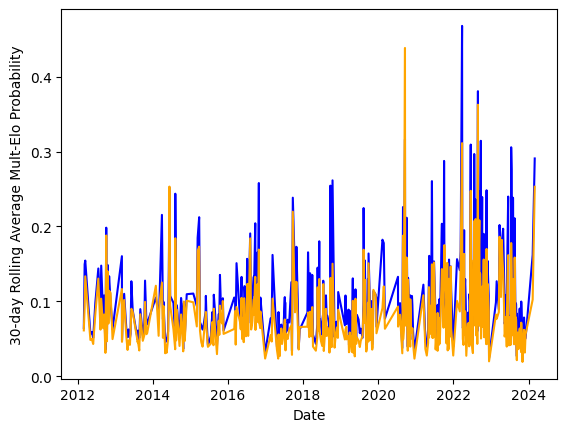

In [26]:
ax = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_multielo_prob",
    color="blue"
)
ax2 = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_multielo_prob_random",
    color="orange"
)
plt.xlabel("Date")
plt.ylabel("30-day Rolling Average Mult-Elo Probability")

In [28]:
metric_df.to_csv('../data/metric_data_multielo.csv')